In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
import random
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# TONDUR, EngSpDist_K1, EngSpDist_K2, MILEAGE

In [3]:
# read the data
df_train = pd.read_csv('./data/train_logged_transformed_data.csv')
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_train.shape

(4621, 17)

In [4]:
# read the data
df_test = pd.read_csv('./data/test_logged_transformed_data.csv')
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]
df_test.shape

(1156, 17)

In [5]:
X_train = scaler.fit_transform(df_train.drop(['LABEL'], axis=1))
y_train = df_train['LABEL'].values
print(X_train.shape, y_train.shape)

(4621, 16) (4621,)


In [6]:
X_test = scaler.transform(df_test.drop(['LABEL'], axis=1))
y_test = df_test['LABEL'].values
print(X_test.shape, y_test.shape)

(1156, 16) (1156,)


For the modeling, baseline needs to established in order to evaluate the performance of the model. For simplicity, I will only consider models from three types: **Linear**, **Non-Linear**, **discriminative algorithm** and **Ensemble**. I will also consider f1 score as a metric for baseline to get the initial feel of the model performance due to high imbalance dataset classes, i.e., ***DAMAGE*** and ***NO_DAMAGE*** are equally important.

### Baseline without upsampling, feature selection (RF, Perm method), and hyperparameters tuning 


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline as imbpipeline

In [8]:
# prepare configuration for cross validation test harness
seed = 7
stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=seed)
def model_evaluation(models, X, y):
    results = []
    names = []
    scoring = 'f1'
    # evaluate each model in turn
    for name, model in models:
        cv_results = model_selection.cross_val_score(model, X, y, cv=stratified_kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s F1 Score: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Models Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
def model_evaluation_sampling(pipl, param_grid, X, y):
    
    
   
    grid_search = GridSearchCV(estimator=pipl,
                               param_grid=param_grid,
                               scoring='f1',
                               cv=stratified_kfold,
                               n_jobs=-1)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    grid_search.fit(X, y)
    cv_score = grid_search.best_score_
    print(f'Cross-validation F1 score: {cv_score}')
    return grid_search.best_estimator_


The following results show that the best performing model is **Random Forest** this task. Cross validation is performed to **avoid overfitting**. For **Logistic Regression** it is performing worse but not as bad as **SVC**. Overall, **Random Forest** outperforms all other models in cross-validation.

LR F1 Score: 0.474958 (0.070113)
DT F1 Score: 0.356608 (0.057532)
RF F1 Score: 0.472625 (0.075825)
SVC F1 Score: 0.336809 (0.085365)


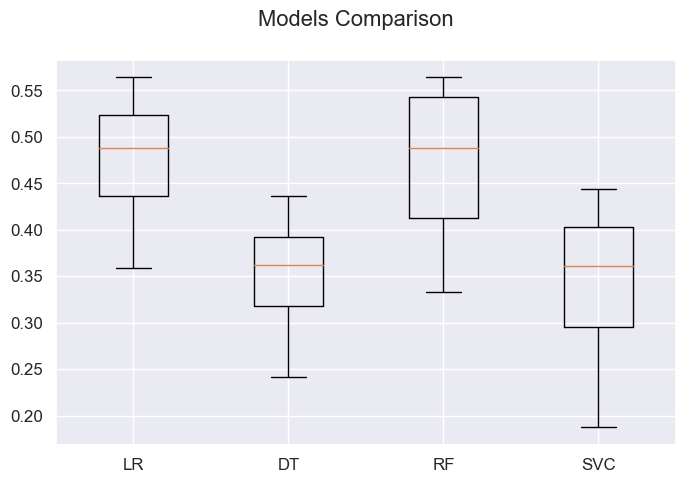

In [9]:

# prepare models
models = []
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC(kernel='rbf')
models.append(('LR', lr))
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('SVC', svc))

model_evaluation(models, X_train, y_train)

As for the baselines, we will consider Logistic Regression (LR) and Random Forest (RF) models that are trained without upsampling, feature selection and hyperparameter tuning. 

### Upsampling without hyperparameter tuning.
In the following blocks, upsampling will be applied to compare the outcomes of the model, and we will consider F1 score as a baseline metric to compare the outcome with baseline models.\
We will consider **SMOTE (Synthetic Minority Oversampling TEchnique)** for this task, as smote is less prone to overfitting as compared to other techniques, e.g., oversampling with replacement. But it is **important** to upsample the data after splitting to avoid **information leakage**.

The following block of cells pass the **imblearn pipeline** as an argument to the model evaluation. The results show that **Random Forest** outperforms logistic and svm model.

In [10]:
from imblearn.over_sampling import SMOTE
pipeline_lr = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', lr]])

param_grid = {}
model_evaluation_sampling(pipeline_lr, param_grid, X_train, y_train)

Cross-validation F1 score: 0.38887507135832367


Pipeline(steps=[('smote', SMOTE(random_state=11)),
                ['classifier', LogisticRegression()]])

In [11]:
pipeline_rf = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', rf]])

model_evaluation_sampling(pipeline_rf, param_grid, X_train, y_train)

Cross-validation F1 score: 0.4967879187303691


Pipeline(steps=[('smote', SMOTE(random_state=11)),
                ['classifier', RandomForestClassifier()]])

In [12]:
pipeline_svc = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', svc]])

model_evaluation_sampling(pipeline_svc, param_grid, X_train, y_train)

Cross-validation F1 score: 0.4267678223625553


Pipeline(steps=[('smote', SMOTE(random_state=11)), ['classifier', SVC()]])

### Undersampling without hyperparameter tuning
We will now undersample the instances based on Tomek-Links method. It looks that Random forest is performing better but same as with oversampling method. We will select Random forest as our model and fine tune to see if we get better performance. Again **Random Forest** outperforms other models.

In [13]:
from imblearn.under_sampling import TomekLinks

In [14]:
tl = TomekLinks(sampling_strategy='auto') 

In [15]:
pipeline_lr = imbpipeline(steps = [['tl', TomekLinks(sampling_strategy='auto') ],
                                ['classifier', lr]])

param_grid = {}
model_evaluation_sampling(pipeline_lr, param_grid, X_train, y_train)

Cross-validation F1 score: 0.48640429425847176


Pipeline(steps=[('tl', TomekLinks()), ['classifier', LogisticRegression()]])

In [16]:
pipeline_rf = imbpipeline(steps = [['tl', TomekLinks(sampling_strategy='auto') ],
                                ['classifier', rf]])

model_evaluation_sampling(pipeline_rf, param_grid, X_train, y_train)

Cross-validation F1 score: 0.476455698076183


Pipeline(steps=[('tl', TomekLinks()), ['classifier', RandomForestClassifier()]])

In [17]:
pipeline_svc = imbpipeline(steps = [['tl', TomekLinks(sampling_strategy='auto') ],
                                ['classifier', svc]])

model_evaluation_sampling(pipeline_svc, param_grid, X_train, y_train)

Cross-validation F1 score: 0.3738019750519751


Pipeline(steps=[('tl', TomekLinks()), ['classifier', SVC()]])

### Oversampling and Hyperparameter tuning with Random Forest

We will now fine tune Random forest with upsampling, i.e., SMOTE with stratified 10-fold cross validation. Due to computation limitations I have selected Random Search CV as the searching algorithm for best parameters. With more fine tuning, we might be able to improve the model. For now I will just go ahead with this as exploratory analysis already shown that features are not really correlated with the dependent variable. 

In [ ]:

pipeline = imbpipeline([("smote", SMOTE()), ("rf", RandomForestClassifier())])


grid = {
    'rf__bootstrap': [True, False],
    'rf__max_depth': [10,15],
    'rf__max_features': [2, 3],
    'rf__min_samples_leaf': [3, 4, 5,6],
    'rf__min_samples_split': [3,4,5,6],
    'rf__n_estimators': [10, 20, 30, 40,50]
}
oversample = SMOTE()




# Just applies smote to the k-1 training folds, and not to the validation fold
search = RandomizedSearchCV(
    pipeline, grid, scoring="f1", n_jobs=-1, cv=stratified_kfold
).fit(X_train, y_train)

best_score = search.best_score_
best_params = {
    key.replace("rf__", ""): value for key, value in search.best_params_.items()
}

print(f"Best Tuning F1 Score: {best_score}")
print(f"Best Tuning Params:   {best_params}")

# EVALUTING BEST MODEL ON TEST SET

best_model = RandomForestClassifier(**best_params).fit(X_train, y_train)


test_pred = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
conf_mat = pd.DataFrame(
    {"Model (0)": [tn, fn], "Model (1)": [fp, tp]}, index=["Actual (0)", "Actual (1)"],
)

classif_report = classification_report(y_test, test_pred)



print(conf_mat)
print("")

print(classif_report)
print("")



In [19]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

In [20]:
precision

0.5882352941176471

In [21]:
recall

0.2857142857142857

In [22]:
f1

0.3846153846153846

In [23]:
best_model

RandomForestClassifier(bootstrap=False, max_depth=15, max_features=2,
                       min_samples_leaf=5, min_samples_split=4,
                       n_estimators=20)

In [69]:
import pickle
filename = './models/tuned_rf_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [70]:
pickle.dump(scaler, open('./models/scaler.sav', 'wb'))